In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# Credit card fraud detection

In [4]:
df = pd.read_csv('data/creditcard.csv')

## Data exploration

In [38]:
print(f"Number of not fraudulent transactions: {df[df['Class']==0]['Class'].count()}\n",
      f"Number of fraudulent transactions: {df[df['Class']==1]['Class'].count()}\n",
      f"Minimum transaction amount: {np.min(df['Amount'])}", 
            f", number of transations: {df[df['Amount']==np.min(df['Amount'])]['Class'].count()}\n",
      f"Maximum transaction amount: {np.max(df['Amount'])}", 
            f", number of transations: {df[df['Amount']==np.max(df['Amount'])]['Class'].count()}", 
            f", class: {df[df['Amount']==np.max(df['Amount'])]['Class'].iloc[0]}\n",
      f"Mean transaction amount: {np.mean(df['Amount'])}\n",
      f"Median transaction amount: {np.median(df['Amount'])}")

Number of not fraudulent transactions: 284315
 Number of fraudulent transactions: 492
 Minimum transaction amount: 0.0 , number of transations: 1825
 Maximum transaction amount: 25691.16 , number of transations: 1 , class: 0
 Mean transaction amount: 88.34961925093133
 Median transaction amount: 22.0


<Axes: title={'center': 'Correlation with Class'}>

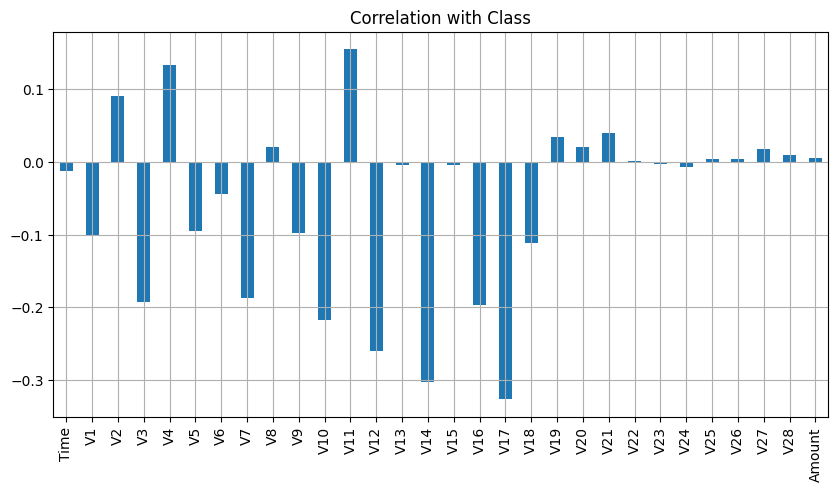

In [15]:
correlation = df.corr()['Class'][0:30]
correlation.plot(kind='bar', figsize=(10,5), title='Correlation with Class', grid=True)

<Axes: >

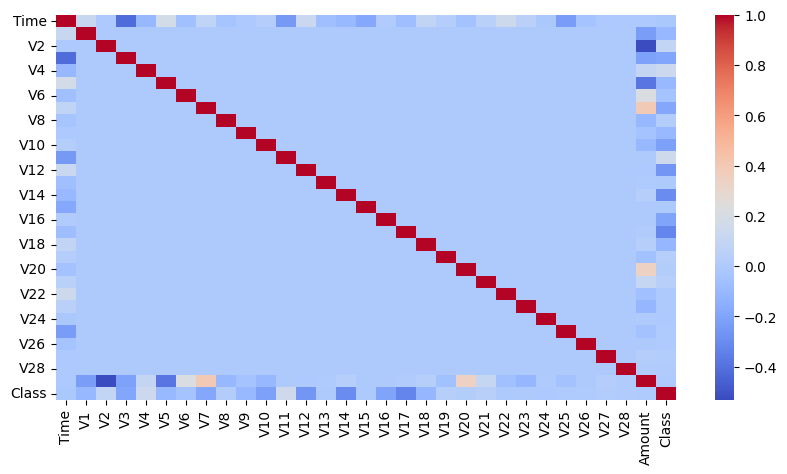

In [33]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False, fmt=".2f")

Amount and class do not correlate, however, Amount and all other variables do correlate. To only keep correlated features, we'll drop anything that has correlation with Class below 0.1

In [5]:
correlated = df.corr()['Class']
df2 = df.copy()
for i in df.columns:
    if abs(correlated[i]) < 0.10:
        df2.drop(columns=[i], inplace=True)
df2.head()

,V1,V3,V4,V7,V10,V11,V12,V14,V16,V17,V18,Class
0,-1.359807,2.536347,1.378155,0.239599,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0
1,1.191857,0.166480,0.448154,-0.078803,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,0
2,-1.358354,1.773209,0.379780,0.791461,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0
3,-0.966272,1.792993,-0.863291,0.237609,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0
4,-1.158233,1.548718,0.403034,0.592941,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0


<Axes: >

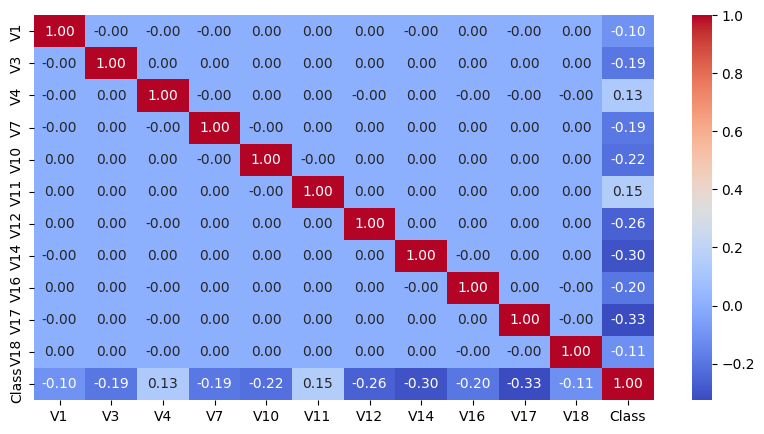

In [31]:
plt.figure(figsize=(10,5))
sns.heatmap(df2.corr(), cmap='coolwarm', annot=True, fmt=".2f")

## Model selection

Data is unbalanced (much more non fraudulent transactions, than fraudulent ones). Therefore, resampling technique needs to be used. Oversampling, where the minority class is artificially increased, might lead to overfitting a model, while undersampling, where the samples from majority class are removed, might result in loss of information. 

Since the amount of fraudulent samples is much smaller than non fraudulent ones, we are choosing not to increase the fraudulent sample number, but to decrease the non fraudulent in hopes not to loose too much information.

In [6]:
from imblearn.under_sampling import RandomUnderSampler

X = df2.drop(columns=['Class'])
y = df2['Class']

rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_resample(X, y)

downsampled = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=['Class'])], axis=1)
downsampled.shape

(984, 12)

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.semi_supervised import LabelSpreading, LabelPropagation

x = downsampled.drop(columns=['Class'])
y = downsampled['Class']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GaussianNB()
clf3 = HistGradientBoostingClassifier(random_state=42)
clf4 = LabelSpreading()
clf5 = LabelPropagation()

ensemble = VotingClassifier(estimators=[('rf', clf1), ('gnb', clf2), ('gbc', clf3), ('label_spreading', clf4), ('label_propagation', clf5)], voting='hard')
ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)


Confusion Matrix:
[[96  3]
 [ 8 90]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        99
           1       0.97      0.92      0.94        98

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197



In credit card fraud detection having false negatives is quite dangerous, in this case 8 FN are returned therefore we need to see if we can lower this number and catch more fraudulent activities. Therefore we could adjust the classification thresholds to catch more false negative values, however, it might increase our false positives. Considering our goal to catch as much fraudulent activity as possible, blocking a few more non-fraudulent payments would be less damaging.

In [61]:
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GaussianNB()
clf3 = HistGradientBoostingClassifier(random_state=42)
clf4 = LabelSpreading()
clf5 = LabelPropagation()

fradulent_catched = VotingClassifier(estimators=[('rf', clf1), ('gnb', clf2), ('gbc', clf3), ('label_spreading', clf4),  ('label_propagation', clf5)], voting='soft')

fradulent_catched.fit(X_train, y_train)

y_probability = fradulent_catched.predict_proba(X_test)[:,1]


threshold = 0.3
y_pred = (y_probability >= threshold).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[95  4]
 [ 4 94]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        99
           1       0.96      0.96      0.96        98

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197

